In [43]:
import pandas as pd
import numpy as np
import re

from feature_extraction import ChatTextFeatures

import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

In [44]:
matplotlib.rcParams.update({'font.size': 15})

In [4]:
df = pd.read_pickle('cleaned_eligibility_data')

### Duplicate tickets

In [4]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...  
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...

In [7]:
dup_t_counts = df[df.text_type == "chat"].groupby('t_id').count()['a_id'].sort_values(ascending=False)

In [8]:
dup_t_counts.value_counts()

1    8689
2     677
3      87
4      21
5       6
6       2
Name: a_id, dtype: int64

In [9]:
dup_t_counts.value_counts()[1:].sum()

793

So 793 tickets had multiple entries, most of them 2 duplicates. Let's look at the typical gap of time between these duplicate entries.

In [10]:
def extract_ts_ends(row):
    try:
        text = row["comment_text"]
        ts = [
            pd.to_datetime(tstring.replace("(", "").replace(")", ""))
            for tstring in re.findall(r"\(.+:.+:.+M\)", text)
        ]
        return [ts[0],ts[-1]]
    except Exception as ex:
        return None

In [11]:
df['ts_ends'] = df[df.text_type == "chat"].apply(extract_ts_ends ,axis=1)

In [12]:
def calc_gaps(grp):
    #merge list of start-end timestamps for a grp of ticket ids
    ts = grp['ts_ends'].agg(lambda x: x.dropna().sum())
    #get list of first timestamps per ticket
    firsts = np.array(ts[0::2][1:])
    lasts = np.array(ts[1::2][:-1])
    return firsts-lasts #gaps between chat

In [13]:
gaps = df.dropna(subset=['ts_ends']).groupby('t_id').apply(calc_gaps)

In [62]:
def gap_stats(gaps_array):
    '''gaps_array: array of array of timedeltas'''
    flattened = np.hstack(gaps_array.dropna())
    return [flattened.min(), flattened.mean(), flattened.max()]

Mean gap is 15 minutes, lets break down by duplicate ticket count.

In [34]:
tdg = pd.DataFrame({'dup_count':dup_t_counts[dup_t_counts>1], 
             'timegap_list':gaps[gaps.map(lambda x: len(x))>0]})

In [63]:
gap_stats(tdg[tdg.dup_count==2]['timegap_list'])

[Timedelta('-1 days +23:58:16'),
 Timedelta('0 days 00:14:21.092261'),
 Timedelta('0 days 02:53:22')]

In [64]:
gap_stats(tdg[tdg.dup_count==3]['timegap_list'])

[Timedelta('0 days 00:00:04'),
 Timedelta('0 days 00:17:07.225433'),
 Timedelta('0 days 02:23:06')]

In [65]:
gap_stats(tdg[tdg.dup_count==4]['timegap_list'])

[Timedelta('0 days 00:00:05'),
 Timedelta('0 days 00:15:31.081967'),
 Timedelta('0 days 01:29:30')]

Samples

In [103]:
tdg.dropna()[tdg.dropna().timegap_list.map(lambda x: any([ts<pd.Timedelta(5,'min') for ts in x]))].\
tail(10)

dup_count                                       timegap_list
96914          2                                  [0 days 00:01:31]
97115          3                 [0 days 00:05:31, 0 days 00:03:30]
97454          3                 [0 days 00:22:51, 0 days 00:04:46]
97614          2                                  [0 days 00:02:47]
97753          4  [0 days 00:06:30, 0 days 00:27:59, 0 days 00:0...
9797           2                                  [0 days 00:00:04]
9802           2                                  [0 days 00:00:23]
98481          2                                  [0 days 00:02:38]
99180          2                                  [0 days 00:04:52]
99526          2                                  [0 days 00:02:49]

In [107]:
[print(i) for i in df[df.t_id=='9802'].comment_text.values];

 
(05:15:47 PM) Claudia Banda: good afternoon
(05:16:02 PM) Amit: Hi Claudia
(05:16:28 PM) Claudia Banda: Hi amit, I am trying to quote a prospect and not sure how to classify them
(05:16:32 PM) Claudia Banda: can you assist me please
(05:16:36 PM) Amit: what are we working with
(05:17:01 PM) Claudia Banda: they are a commercial light industrial mechanical piping/general labor
(05:17:29 PM) Claudia Banda: 20% HVAC 20% INSULATION 10% PAINTING
(05:17:52 PM) Claudia Banda: 10% GRADING. I am going based on a sup app I got completed from the prospect
(05:18:08 PM) Claudia Banda: oops and 10% drywall/plastering
(05:18:20 PM) Amit: general contractor is kinda sounds like
(05:19:02 PM) Claudia Banda: well only 30% is subed out
(05:20:04 PM) Amit: it will all be rated on payroll
(05:20:12 PM) Amit: so I would pick the most appropriate class available
(05:20:28 PM) Claudia Banda: ok I have that
(05:21:51 PM) Claudia Banda: what class would that be you think
(05:21:55 PM) Claudia Banda: ?
(05:22:

### Text feature extraction class

In [338]:
df.t_created.map(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')[:10]).head()

0    2019-09-19
1    2019-09-19
2    2019-09-19
3    2019-09-19
4    2019-09-19
Name: t_created, dtype: object

In [3]:
print(df.comment_text[0])

 
(09:57:41 PM) Jeannie: Hi
(09:58:11 PM) Shane C.: Hi Jeannie
(09:58:13 PM) Shane C.: How are you?
(09:58:22 PM) Jeannie: HI Shane
(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"
(09:58:58 PM) Jeannie: they are bakery with cooking
(09:59:06 PM) Jeannie: not sure what's the best class I should go with
(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops
(09:59:53 PM) Jeannie: not sure if this is appropriate?
(10:00:00 PM) Jeannie: there is no specific bakery with cooking
(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311
(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing
(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)
(10:02:47 PM) Jeannie: Have a great day. TY
(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?
(10:03:19 PM) Jeannie: I'm good now. TY :)
(10:03:39

In [8]:
test = ChatTextFeatures(df.comment_text[0], '2019-11-01')

In [9]:
test.TIMESTAMP_NAME_PATTERN

'\\((.+:.+:.+ [AP]M)\\) (.+?):'

In [11]:
test.parsed_chat[:2]

[OrderedDict([('name', 'Jeannie'),
              ('text', 'Hi'),
              ('timestamp', Timestamp('2019-11-01 21:57:41')),
              ('author', 'broker')]),
 OrderedDict([('name', 'Shane C.'),
              ('text', 'Hi Jeannie'),
              ('timestamp', Timestamp('2019-11-01 21:58:11')),
              ('author', 'agent')])]

### Merging tickets

In [5]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...  
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...

In [10]:
def echeck(row):
    print(row.index)
    return ChatTextFeatures(row['comment_text'])
df['ctf'] = df.apply(lambda x: echeck(x), axis=1)

In [6]:
df['ctf'] = df.apply(lambda x: ChatTextFeatures(x['comment_text'], 
                                                x['t_created'].strftime('%Y-%m-%d %H:%M:%S')[:10]), axis=1)

In [7]:
def add_column_from_attribute(df, obj_col, att):
    '''Add df column "att" where value is extract from obj_col.att'''
    df[att] = df[obj_col].map(lambda x: eval('x.{}'.format(att)))

In [8]:
# df['text_type'] = df.ctf.map(lambda x: x.text_type)
# df['parsed_chat'] = df.ctf.map(lambda x: x.parsed_chat)
# df['num_parsing_errors'] = df.ctf.map(lambda x: x.num_parsing_errors)
# df['timestamp_features'] = df.ctf.map(lambda x: x.timestamp_features)

In [9]:
for c in ['text_type','parsed_chat', 'num_parsing_errors', 'timestamp_features', 'tsf_error']:
    add_column_from_attribute(df, 'ctf',c)

In [10]:
df.head(2)

t_id           t_created   r_name          r_id          a_id    a_name  \
0  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   
1  148945 2019-09-19 21:58:13  Jeannie  363946897231  374984390592  Shane C.   

             subject                                       comment_text  \
0  Chat with Jeannie   \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Sh...   
1  Chat with Jeannie  Hi Jeannie,\nThank you for contacting us. The ...   

                                                 ctf text_type  \
0  <feature_extraction.ChatTextFeatures object at...      chat   
1  <feature_extraction.ChatTextFeatures object at...     macro   

                                         parsed_chat  num_parsing_errors  \
0  [{'text': 'Hi', 'timestamp': 2019-09-19 21:57:...                   0   
1                                               None                   0   

                                  timestamp_features tsf_error  
0  {'diffs': [0.5, 0.03333333333333333, 0.15, 0.4...     False  
1  {'diffs': None, 'mean_diffs': None, 'max_diffs...      None

In [11]:
df[df.num_parsing_errors>0]['t_id'].count()

8

In [12]:
def get_merged_indices(grp):
    #only merge for duplicate ticketIDs
    if len(grp)>1:
        #print('grp: {}'.format(grp.name))
        #get first and last timestamps from all timestamps
        #extracted from a ticket
        def get_ends(ctf):
            ts_list = ctf.get_chat_component('timestamp')
            if len(ts_list)>1:
                return [ts_list[0],ts_list[-1]]
            else:
                return [ts_list[0]]

        #get list of timestamp ends for group
        ends = grp['ctf'].map(get_ends).values
        inds = grp.index.values
        
        #if parsing error, exit
        if None in np.hstack(ends):
            return None
        
        #iterate over ends, marking those to merge w previous
        merge_bool = []
        
        for i, ts_list in enumerate(ends):
            if i==0:
                merge_bool.append(False)
            elif len(ts_list)==1:
                merge_bool.append(True)
            else:
                #end timestamp from previous row
                previous_row = ends[i-1]
                if len(previous_row)==1:
                    previous_end_ts = previous_row[0]
                else:
                    previous_end_ts = previous_row[1]
                current_first_ts = ts_list[0]
                diff = current_first_ts - previous_end_ts
                if diff<=pd.Timedelta(5,'min'):
                    merge_bool.append(True)
                else:
                    merge_bool.append(False)
        
        #use merge_bool to merge indices
        merged_inds_list = []
        for i, b in enumerate(merge_bool):
            if not b:
                merged_inds_list.append([inds[i]])
            else:
                merged_inds_list[-1].append(inds[i])
        
        #iterate over merged inds list and merge text & create new ticket IDs
        new_ticket_text_list = []
        for i,ind_list in enumerate(merged_inds_list):
            old_id = grp.loc[ind_list[0]]['t_id']
            new_id = "{}_{}".format(old_id, str(i))
            new_text = "\n".join([grp.loc[j]['comment_text'] for j in ind_list])
            new_ticket_text_list.append([new_id, new_text])
        
#         print(ends)
#         print(inds)
#         print(merged_inds_list)
#         print(new_ticket_text_list)
        return new_ticket_text_list
    else:
        return None

In [13]:
new_ticket_data = df[df.text_type=='chat'].groupby('t_id').apply(get_merged_indices).dropna()

In [14]:
new_ticket_df = pd.DataFrame(np.vstack(new_ticket_data.values), columns=['new_t_id','comment_text'])

In [15]:
# make new df to merge with old
new_ticket_df.head(2)

new_t_id                                       comment_text
0  100130_0   \n(08:23:00 PM) Christina : Hello, please adv...
1  100130_1  (08:59:12 PM) Christina : Hello David\n(08:59:...

In [16]:
new_ticket_df['t_id'] = new_ticket_df.new_t_id.map(lambda x: x[:-2])

In [17]:
tid_tcreated_df = df[df.t_id.isin(new_ticket_df.t_id.values)][['t_id','t_created']].drop_duplicates().copy()

In [18]:
new_ticket_df = new_ticket_df.merge(tid_tcreated_df, on='t_id', how='left')

In [19]:
new_ticket_df.head(2)

new_t_id                                       comment_text    t_id  \
0  100130_0   \n(08:23:00 PM) Christina : Hello, please adv...  100130   
1  100130_1  (08:59:12 PM) Christina : Hello David\n(08:59:...  100130   

            t_created  
0 2019-05-29 20:33:07  
1 2019-05-29 20:33:07

In [20]:
new_ticket_df['ctf'] = new_ticket_df.apply(lambda x: ChatTextFeatures(x['comment_text'], 
                                                x['t_created'].strftime('%Y-%m-%d %H:%M:%S')[:10]), axis=1)
# new_ticket_df['text_type'] = new_ticket_df.ctf.map(lambda x: x.text_type)
# new_ticket_df['parsed_chat'] = new_ticket_df.ctf.map(lambda x: x.parsed_chat)
# new_ticket_df['num_parsing_errors'] = new_ticket_df.ctf.map(lambda x: x.num_parsing_errors)
# new_ticket_df['timestamp_features'] = new_ticket_df.ctf.map(lambda x: x.timestamp_features)

In [21]:
for c in ['text_type','parsed_chat', 'num_parsing_errors', 'timestamp_features', 'tsf_error']:
    add_column_from_attribute(new_ticket_df, 'ctf',c)

In [22]:
new_ticket_df.head(2)

new_t_id                                       comment_text    t_id  \
0  100130_0   \n(08:23:00 PM) Christina : Hello, please adv...  100130   
1  100130_1  (08:59:12 PM) Christina : Hello David\n(08:59:...  100130   

            t_created                                                ctf  \
0 2019-05-29 20:33:07  <feature_extraction.ChatTextFeatures object at...   
1 2019-05-29 20:33:07  <feature_extraction.ChatTextFeatures object at...   

  text_type                                        parsed_chat  \
0      chat  [{'text': 'Hello, please advise', 'timestamp':...   
1      chat  [{'text': 'Hello David', 'timestamp': 2019-05-...   

   num_parsing_errors                                 timestamp_features  \
0                   0  {'diffs': [1.15, 0.9666666666666667, 0.3333333...   
1                   0  {'diffs': [0.16666666666666666, 0.2, 1.4333333...   

   tsf_error  
0      False  
1      False

Remove ticket with duplicates from old df

In [23]:
df['new_t_id'] = df['t_id']

In [24]:
df_single = df[~df.t_id.isin(new_ticket_data.index.values)].copy()

Union old and new

In [25]:
df_single.iloc[0].comment_text

' \n(09:57:41 PM) Jeannie: Hi\n(09:58:11 PM) Shane C.: Hi Jeannie\n(09:58:13 PM) Shane C.: How are you?\n(09:58:22 PM) Jeannie: HI Shane\n(09:58:50 PM) Jeannie: In reg to quote for "Fresh Donuts Inc"\n(09:58:58 PM) Jeannie: they are bakery with cooking\n(09:59:06 PM) Jeannie: not sure what\'s the best class I should go with\n(09:59:47 PM) Jeannie: I choose on buz category for Restaurant fast food, class as Donut shops\n(09:59:53 PM) Jeannie: not sure if this is appropriate?\n(10:00:00 PM) Jeannie: there is no specific bakery with cooking\n(10:00:11 PM) Shane C.: Bakeries-Retail-With Baking on Premises 71311\n(10:00:37 PM) Shane C.: I think this would be the best class code under processing and servicing\n(10:01:12 PM) Jeannie: How the bakery goes in Processing &amp; Servicing.. LOL. I found the bakeries class. TY :)\n(10:02:47 PM) Jeannie: Have a great day. TY\n(10:03:07 PM) Shane C.: My pleasure. Is there anything else I can help with at the moment?\n(10:03:19 PM) Jeannie: I\'m good n

In [26]:
df_final = df_single.append(new_ticket_df, ignore_index=True,sort=False)

In [27]:
df_final.t_id.unique().size

9495

In [28]:
df_final.new_t_id.unique().size

10085

~6% effect (9495 -> 10085 tickets)

In [29]:
df_final.to_pickle('merged_parsed_chat')

### Explore long tickets

- exploration of longer tickets (timestamp features of tickets distribution)
- see if topic analysis will be relevant with first 3 lines.

In [33]:
df_final[(df_final.text_type=='chat') & (df_final.tsf_error)].count()

t_id                  80
t_created             80
r_name                71
r_id                  71
a_id                  71
a_name                71
subject               71
comment_text          80
ctf                   80
text_type             80
parsed_chat           80
num_parsing_errors    80
timestamp_features    80
tsf_error             80
new_t_id              80
dtype: int64

In [34]:
df_final['rounded_total'] = df_final[df_final.text_type=='chat'].timestamp_features.map(lambda x: x['rounded_total'])

In [35]:
df_final.count()

t_id                  12245
t_created             12245
r_name                10870
r_id                  10870
a_id                  10870
a_name                10870
subject               10867
comment_text          12245
ctf                   12245
text_type             12245
parsed_chat           10085
num_parsing_errors    12245
timestamp_features    12245
tsf_error             10085
new_t_id              12245
rounded_total         10005
dtype: int64

In [40]:
def get_hist(data_series, step):
    '''Given a pandas Series of continuous data (like quote premiums),
    return histogram data with equally spaced bins given by step.
    
    Returns
    -------
    list(array):[bins(right edges), histogram counts]
    '''
    if data_series.min()<0:
        hist_min = data_series.min()-step
    else:
        hist_min = 0
    result = np.histogram(data_series.values, bins=np.arange(hist_min,data_series.max()+step,step))
    return [result[1][1:],result[0]]

In [41]:
def plot_hist(hist_data, xlabel='xaxis', ylabel='yaxis',title='title', cumulative=False, max_scale=False):
    fig, ax = plt.subplots()
    x = hist_data[0]
    y = hist_data[1]
    if cumulative:
        y = y.cumsum()
    if max_scale:
        y = y/y.max()
    ax.plot(x,y,'.',ms=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
    
    return ax

In [48]:
plot_hist(get_hist(df_final.rounded_total.dropna().sort_values()[1:], 1), 
          xlabel='ticket_time', ylabel='num_tickets',title=None, cumulative=True, max_scale=True)

<IPython.core.display.Javascript object>

In [49]:
df_final[df_final.rounded_total>5].timestamp_features.head().iloc[0]

OrderedDict([('diffs',
              [0.65,
               0.03333333333333333,
               0.9833333333333333,
               2.6166666666666667,
               0.35,
               2.716666666666667,
               1.7333333333333334,
               0.16666666666666666,
               3.5833333333333335,
               0.9166666666666666]),
             ('mean_diffs', 1.375),
             ('max_diffs', 3.5833333333333335),
             ('rounded_total', 13),
             ('total', 13.1)])

In [50]:
#examine how many large tickets have large jumps
df_final['max_diffs'] = df_final.timestamp_features.map(lambda x: x['max_diffs'])

<IPython.core.display.Javascript object>


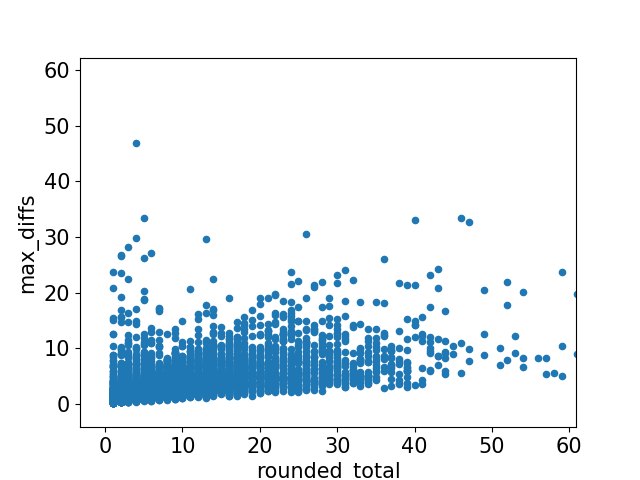

In [51]:
df_final[df_final.rounded_total>0].plot(x='rounded_total',y='max_diffs', kind='scatter')

Rounded totals smaller than max_diff?

Max difference greater than total ticket times, likely because of delay in first response by agent or final chat by broker

In [55]:
y = (df_final.max_diffs-df_final.rounded_total).dropna().sort_values()

In [57]:
plot_hist(get_hist(y,1), xlabel='max_diff - rounded_total', ylabel='num_tickets', title=None)

<IPython.core.display.Javascript object>

In [59]:
df_final['max-total'] = (df_final.max_diffs-df_final.rounded_total)

<IPython.core.display.Javascript object>


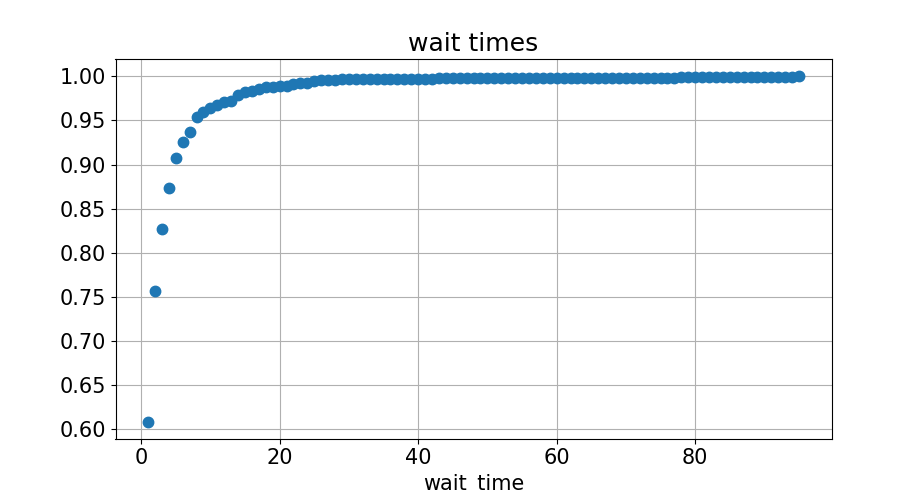

In [80]:
plot_hist(get_hist(df_final[df_final['max-total']>0].sort_values('max-total', ascending=False)['max-total'],1), 
          cumulative=True, max_scale=True, xlabel='wait_time', ylabel=None, title='wait times')

In [96]:
print(df[df.t_id=='65801'].comment_text.iloc[1])

(04:41:34 PM) Mark: Hello - I have a couple of questions regarding named insured and WC class codes


In [127]:
print(df_final[df_final['max-total']>0].sort_values('max-total', ascending=False).iloc[9].comment_text)

 
(04:31:34 PM) Natalia Safar: Looking for an
art exhibitor classification
(04:55:03 PM) Amit: Hello
(04:55:04 PM) Amit: how are you
(04:56:17 PM) Natalia Safar: Hello
(04:56:29 PM) Natalia Safar: Ia m Looking for an
art exhibitor classification
(04:56:36 PM) Amit: we don't offer a class for this sorry
(04:56:42 PM) Natalia Safar: thank you!
(04:56:50 PM) Amit: you are welcome
(04:56:51 PM) Amit: take care



In [110]:
df_final[df_final['max-total']>0].sort_values('max-total', ascending=False).\
ctf.map(lambda x: x.get_chat_component('timestamp','agent')).iloc[1]

[Timestamp('2019-04-11 21:00:10'),
 Timestamp('2019-04-11 21:00:27'),
 Timestamp('2019-04-11 21:00:42'),
 Timestamp('2019-04-11 21:01:04'),
 Timestamp('2019-04-11 21:01:25'),
 Timestamp('2019-04-11 21:02:02'),
 Timestamp('2019-04-11 21:02:09'),
 Timestamp('2019-04-11 21:05:26'),
 Timestamp('2019-04-11 21:09:41'),
 Timestamp('2019-04-11 21:13:05'),
 Timestamp('2019-04-11 21:13:19'),
 Timestamp('2019-04-11 21:14:27')]

Add feature to see if large gap was part of total time

In [129]:
df_final.rename(columns={'max-total':'max_total_diff'}, inplace=True)

In [132]:
df_final['max_total_ratio']  = df_final.max_diffs/df_final.rounded_total

In [146]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [167]:
mtdf = df_final[(df_final.max_total_ratio<=1) & (df_final.rounded_total<=30)].\
sort_values('max_total_ratio',ascending=False)[['rounded_total','max_total_ratio']]

In [172]:
mtdf.head()

rounded_total  max_total_ratio
450             4.0              1.0
7261            3.0              1.0
5201            7.0              1.0
5891            2.0              1.0
4809            4.0              1.0

In [175]:
mtdf.corr()

rounded_total  max_total_ratio
rounded_total         1.000000        -0.297774
max_total_ratio      -0.297774         1.000000

In [ ]:
mtdf pd.crosstab()

In [180]:
import seaborn as sns
# sns.set(style="white")

x1 = mtdf.rounded_total
x2 = mtdf.max_total_ratio

# Show the joint distribution using kernel density estimation
# g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)

<IPython.core.display.Javascript object>


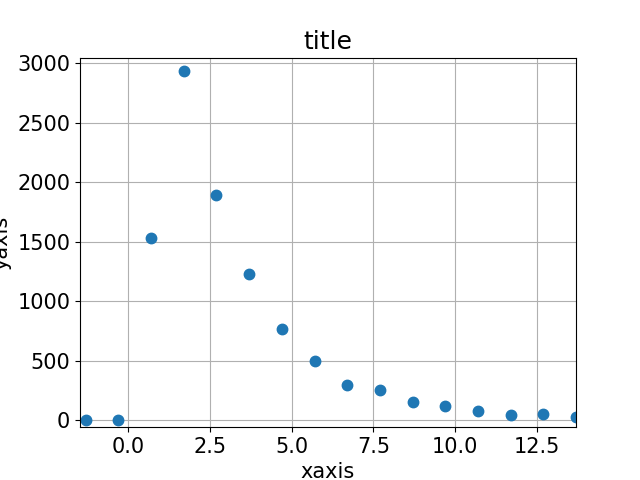

In [179]:
plot_hist(get_hist(df_final.max_diffs.dropna(),1)),

Most max differences in timestamps <= 3 mins

In [192]:
for i in df_final[(df_final.max_total_ratio<=1) & (df_final.rounded_total>=5) & (df_final.max_total_ratio>=.5)].\
sort_values('max_total_ratio',ascending=False).sample(5).comment_text:
    print(i)

 
(04:14:41 PM) Christina : Hello!
(04:14:55 PM) Brian H: Hi Christina, how are you today?
(04:15:52 PM) Christina : Can I quote a LRO -Building occupied by wholesaler of man clothing
(04:16:08 PM) Christina : I'm great Brian hope you are great as well.
(04:16:30 PM) Christina : wholesaler of man clothing and office.
(04:17:00 PM) Brian H: I believe so, let me just confirm.
(04:19:08 PM) Brian H: Yes we have a class code for this risk - clothing or wearing apparel - distributors - men's and boy's clothing and furnishings. The only contingencies are that the risk would be ineligible if they are selling products under the insured's name, manufacturing, importing goods, or repackaging and/or relabeling products.
(04:34:55 PM) Brian H: If you have any further questions or concerns, please don't hesitate to reach back out!

 
(04:42:31 PM) Gelarah: Need class for furniture repair contractor
(04:45:09 PM) Brian H: Hi Gelarah, how are you today?
(04:49:00 PM) Gelarah: Hello
(04:49:18 PM) Bria

Look at total agent time vs total broker response time

In [203]:
test = df_final.iloc[0].ctf.get_chat_component('author')
#flag inidices of change
author_change_inds = []
for i,a in enumerate(test):
    if i>0:
        if a!=test[i-1]:
            author_change_inds.append(i)

In [204]:
author_change_inds

[1, 3, 10, 12, 14, 15, 16]

In [216]:
np.array(test)[author_change_inds][0::1]

array(['agent', 'broker', 'agent', 'broker', 'agent', 'broker', 'agent'],
      dtype='<U6')